In [1]:
naam = "Onno de Jong"
opdracht = "Inleveropdracht 2: Logistic Regression & Naïve Bayes"
deel = 2

In [2]:
import nltk
from nltk.tokenize import TweetTokenizer
nltk.download("twitter_samples")
nltk.download("stopwords")
from string import punctuation
from nltk.stem import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from nltk.corpus import twitter_samples
from nltk.corpus import stopwords

import math
import numpy as np

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\maste\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maste\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
tokenizer = TweetTokenizer()
swords = stopwords.words("english")
stemmr = PorterStemmer()

def filtertxt(text, filtr):
    return nltk.re.sub(filtr, "", text)

def removewords(text, filtr):
    return [word for word in text if word not in filtr]

def clean(tweet, printsteps=False):
    print("origineel \t\t", tweet) if printsteps else None
    # rt's verwijderen, het is geen nuttige informatie dat we weten oof de tweet een retweet is voor ons doel
    tweet = filtertxt(tweet, "RT")
    print("Filter de RT's \t\t", tweet) if printsteps else None
    
    # #'s verwijderen, een # is in principe een leesteken maar met de tweettokenizer wordt de hele hashtag 
    # als 1 token gezien dus we moet hier al de #'s eruit halen, ook is het geen nuttige informatie
    tweet = filtertxt(tweet, "#")
    print("Filter de #'s' \t\t", tweet) if printsteps else None
     
    # tokenize de tweet
    tweet = tokenizer.tokenize(tweet)
    print("Tokenize de tweet \t", tweet) if printsteps else None
    
    # stopworden uit de tweet halen, geen nuttige informatie, deze worden geven niet aan of het een blije of een boze tweet is
    tweet = removewords(tweet, swords)
    print("verwijder stopworden \t", tweet) if printsteps else None
    
    # punctuatie uit de tweet halen, geen nuttige informatie, punctuatie geeft niet aan of het een blije of een boze tweet is
    tweet = removewords(tweet, punctuation)
    print("verwijder punctuatie \t", tweet) if printsteps else None
    
    # stemmer toepassen op de worden, omdat we zometeen de worden gaan tellen is het van groot belang dat de worden allemaal in dezelfde vorm staan,
    # bijvoorbeeld "invitation" en "invite" worden allebei "invit"
    tweet = list(map(stemmr.stem, tweet))
    print("stem de tweet \t\t", tweet) if printsteps else None
    
    # de tweet is helemaal opgeschoond en klaar voor gebruik
    return tweet

frequencies uit een lijst van tweets halen

In [4]:
def counttweets(tweets, pos):
    freq = {}
    for tweet in tweets:
        for word in tweet:
            if (word, pos) in freq.keys():
                freq[(word, pos)] += 1
            else:
                freq[(word, pos)] = 1
    return freq

def getres(tweets):
    res = {}
    done = []
    for word, pos in tweets.keys():
        if word in done:
            continue
            
        done.append(word)
        # als het tegendeel niet bestaat is het 0
        neg_res = 0 if (word, 0.0) not in tweets.keys() else tweets[word, 0.0]
        pos_res = 0 if (word, 1.0) not in tweets.keys() else tweets[word, 1.0]
        res[word] = [pos_res, neg_res]
                
    return res

maken van een dict van frequencies van de positieve en negatieve tweets en dan bij elkaar voegen 

In [5]:
pos_freq_tweets = counttweets([clean(tweet) for tweet in twitter_samples.strings('positive_tweets.json')], 1.0)
neg_freq_tweets = counttweets([clean(tweet) for tweet in twitter_samples.strings('negative_tweets.json')], 0.0)

freqs = getres(pos_freq_tweets | neg_freq_tweets)
len(freqs)

19419

In [6]:
freqs

{'followfriday': [25, 0],
 '@france_int': [1, 0],
 '@pkuchly57': [1, 0],
 '@milipol_pari': [1, 0],
 'top': [32, 6],
 'engag': [7, 0],
 'member': [16, 6],
 'commun': [33, 2],
 'week': [83, 56],
 ':)': [3691, 2],
 '@lamb2ja': [1, 0],
 'hey': [77, 26],
 'jame': [7, 4],
 'how': [24, 23],
 'odd': [2, 3],
 ':/': [5, 11],
 'pleas': [99, 275],
 'call': [37, 29],
 'contact': [7, 7],
 'centr': [2, 2],
 '02392441234': [1, 0],
 'abl': [8, 23],
 'assist': [1, 0],
 'mani': [33, 29],
 'thank': [643, 107],
 '@despiteoffici': [1, 0],
 'listen': [17, 18],
 'last': [47, 73],
 'night': [68, 46],
 'as': [5, 9],
 'you': [123, 84],
 'bleed': [2, 1],
 'amaz': [51, 16],
 'track': [5, 3],
 'when': [14, 30],
 'scotland': [2, 2],
 '@97side': [1, 0],
 'congrat': [21, 2],
 'yeaaaah': [1, 0],
 'yippppi': [1, 0],
 'accnt': [2, 0],
 'verifi': [2, 0],
 'rqst': [1, 0],
 'succeed': [1, 0],
 'got': [69, 104],
 'blue': [9, 5],
 'tick': [1, 0],
 'mark': [1, 2],
 'fb': [6, 7],
 'profil': [2, 1],
 '15': [5, 10],
 'day': [246,

19419 is een beetje veel maar later zien we dat dat niet heel erg is </br> 
Train en test sets maken met een split van 80/20

In [7]:
# trainset
trainset = twitter_samples.strings('positive_tweets.json')[:int(len(twitter_samples.strings('positive_tweets.json')) * .8)] \
                                       + twitter_samples.strings('negative_tweets.json')[:int(len(twitter_samples.strings('negative_tweets.json')) * .8)]

# validatieset
validatieset = twitter_samples.strings('positive_tweets.json')[int(len(twitter_samples.strings('positive_tweets.json')) * .8):] \
                                           + twitter_samples.strings('negative_tweets.json')[int(len(twitter_samples.strings('negative_tweets.json')) * .8):]

print(len(trainset), len(validatieset))

8000 2000


In [8]:
def sigmoid(z):
    """sigmoid functie, werkt met een lijst, een int of een float"""
    if isinstance(z, float) or isinstance(z, int):
        return 1/(1 + math.e**-z)
    
    if hasattr(z, '__iter__'):
        return np.array([1/(1 + math.e**-x) for x in z])

sigmoid functie testen

In [9]:
sigmoid(0)

0.5

In [10]:
sigmoid([4.92, 4.92, 4.92, 4.92])

array([0.99275376, 0.99275376, 0.99275376, 0.99275376])

In [11]:
def gradient_descent(x, y, theta, alpha, num_iters):
    """
    eigenlijk een 1 layer neural network
    
    Input:
    x: matrix van features, dimensies (m,n+1)
    y: corresponderende labels van de input matrix x, dimensies (m,1)
    theta: weights vector, dimensies (n+1,1)
    alpha: learning rate
    num_iters: aantal iterations om het model te trainen
    
    Output:
    J: de laatste cost
    theta: de geleerde weights vector
    """
    print(x.shape)
    print(y.shape)
    print(theta.shape)
    print(alpha)
    print(num_iters)
    
    # loop over het aantal epochs heen
    for i in range(num_iters):
#         print(i)
        # door de input matrix * het model te doen maken we een voorspelling van alle inputs
        z = np.matmul(x, theta)
        
        # sigmoid van alle voorspellingen
        h = sigmoid(z)
        
        # hier rekenen we de cost van het netwerk uit, we gebruiken dit verder niet het is alleen om te zien hoe goed het
        # model getrained is
        J = (-1/x.shape[0]) * (np.matmul(y.transpose(), np.log(h)) + np.matmul((1-y).transpose(), np.log(1-h)))
        
        # het leren van de samples, learning rate / N samples * input * errors
        theta = theta - alpha/x.shape[0] * (np.matmul(x.transpose(), (h - y)))
        
    return [J, theta]

testen van de functie

In [12]:
np.random.seed(1)
# X input is 10 x 3 met 1 voor de bias terms
test_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)
# Y labels zijn 10 x 1
test_Y = (np.random.rand(10, 1) > 0.35).astype(float)

gradient_descent(test_X, test_Y, np.array([0] * test_X.shape[1]).reshape(-1,1), 1e-8, 700)

(10, 3)
(10, 1)
(3, 1)
1e-08
700


[array([[0.6709497]]),
 array([[4.10713435e-07],
        [3.56584699e-04],
        [7.30888526e-05]])]

functie om de freq's van de tweet te nemen en dan de positieve en negatieve values uit de frequencie tabel die we eerder hebben gemaakt op te tellen

In [13]:
def feature_extraction(tweet, freq):
    pos = 0
    neg = 0
    for word in tweet:
        pos += freq[word][0]
        neg += freq[word][1]
    return [pos, neg]

In [14]:
feature_extraction(clean(trainset[0]), freqs)

[3890, 72]

er is een lichte afwijking in waardes door de keuzes die gemaakt zijn in de cleaning functie

In [15]:
train_x = np.array([[1] + feature_extraction(clean(x), freqs) for x in trainset])

train_y = [1] * int(len(twitter_samples.strings("positive_tweets.json")) * .8) + [0] * int(len(twitter_samples.strings("negative_tweets.json")) * .8)
train_y = np.array(train_y)

print(len(train_x), len(train_y))

8000 8000


netwerk trainen met 80% van de twitter dataset

In [16]:
cost, network = gradient_descent(train_x, train_y.astype("float").reshape(-1,1), np.array([0] * train_x.shape[1]).reshape(-1,1), 1e-9, 1500)

(8000, 3)
(8000, 1)
(3, 1)
1e-09
1500


aan de scatterplot is duidelijk te zien hoe de data zich verdeelt en ook welke tweets hij (waarschijnlijk) verkeerd doet

[]

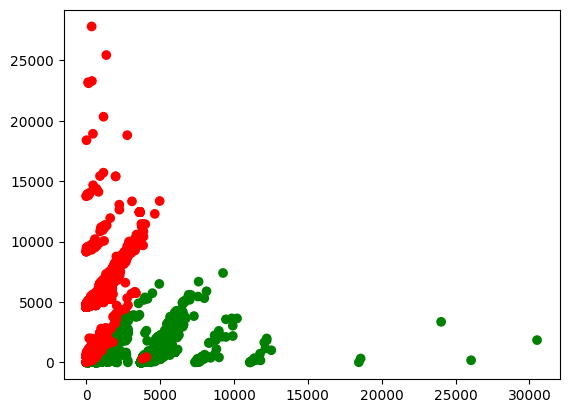

In [17]:
plt.scatter(train_x[:, 1], train_x[:, 2], c=['red' if x == 0 else 'green' for x in train_y])
plt.plot()

In [18]:
def predict(tweet, freqs, network):
    return sigmoid(np.matmul(np.array([1] + feature_extraction(clean(tweet), freqs)), network))

In [19]:
print('"I am happy" -> 0.519275', end=" | ")
print(predict("I am happy", freqs, network))
print('"I am bad" -> 0.494347', end=" | ")
print(predict("I am bad", freqs, network))
print('"this movie should have been great." -> 0.515980', end=" | ")
print(predict("this movie should have been great.", freqs, network))
print('"great" -> 0.516065', end=" | ")
print(predict("great", freqs, network))
print('"great great" -> 0.532097', end=" | ")
print(predict("great great", freqs, network))
print('"great great great" -> 0.548063', end=" | ")
print(predict("great great great", freqs, network))
print('"great great great great" -> 0.563930', end=" | ")
print(predict("great great great great", freqs, network))

"I am happy" -> 0.519275 | [0.44777648]
"I am bad" -> 0.494347 | [0.41456519]
"this movie should have been great." -> 0.515980 | [0.52192803]
"great" -> 0.516065 | [0.52162747]
"great great" -> 0.532097 | [0.54317414]
"great great great" -> 0.548063 | [0.56456046]
"great great great great" -> 0.563930 | [0.58570922]


waardes zijn niet 1 op 1 hetzelfde maar het komt redelijk in de buurt, dit komt door de keuzes die zijn gemaakt in de cleaning functie maar het komt wel redelijk in de buurt

In [20]:
def accuracy(test_x, test_y, freqs, theta):
    good = 0
    for index, tweet in enumerate(test_x):
         if test_y[index] == (1 if predict(tweet, freqs, theta) > .5 else 0):
                good += 1
    
    return good/len(test_y)

In [21]:
test_x = validatieset
test_y = np.array([1] * int(len(validatieset) / 2) + [0] * int(len(validatieset) / 2))
accuracy(test_x, test_y, freqs, network)

0.986

ook de accuracy is niet 1 op 1 maar hij doet het nog steeds best wel goed